# Webinar - airline delays

W trakcie webinaru poznamy _Excelowy_ odpowiednik w Pythonie czyli Pandas. W arkuszu zapoznamy się:
- jak zaczytać plik `csv`, z którym arkusz kalkulacyjny po prostu by nie dał rady,
- przeglądnąć dane i sprawdzić czy nie ma oczywistych błędów,
- dokonać elementranej analizy eksporacyjnej.

Jako studium przypadkum przyjmiemy, że chcemy znaleźć czynnik (zmienną), która odpowiada za to, że samoloty łapią opóźnienie od rozkładu.

In [1]:
import os
import pandas as pd

In [2]:
def get_month_from_filename(file_name: str) -> int:
    """
    Funkcja, która na podstawie nazwy pliku zwraca miesiąc, z którego dane pochodzą
    """
    month = file_name[-6:-4]
    return month

In [3]:
def read_raw_csv(file_name: str, month: int) -> pd.DataFrame:
    df = pd.read_csv(file_name)
    df["file_month"] = month

    return df

### Wczytanie poszczególnych plików do jednej zbiorczej ramki
Najpierw zapiszemy sobie wszystko do słownika, gdzie kluczem będzie numer miesiąca a potem wszystko skleimy w jedną, dużą

In [4]:
data = {}
data_dir = "./data/raw"

for file in os.scandir(data_dir):
    if file.name == '.gitkeep':
        continue
    
    file_path = os.path.normpath(os.path.join(data_dir, file.name))

    month = get_month_from_filename(file.name)
    data[month] = read_raw_csv(file_path, month)


Złączenie poszczególnych ramek w jedną

In [5]:
df_raw = pd.concat([x for _, x  in data.items()])

Tworzymy ramkę, na której będziemy pracować do końca notebook'a

Wybieramy podzbiór kolumn, za pomocą których będziemy analizować dane

# Przegląd danych

In [7]:
df_raw.head()
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7422037 entries, 0 to 625762
Data columns (total 34 columns):
 #   Column               Dtype  
---  ------               -----  
 0   MONTH                int64  
 1   DAY_OF_MONTH         int64  
 2   DAY_OF_WEEK          int64  
 3   OP_UNIQUE_CARRIER    object 
 4   TAIL_NUM             object 
 5   OP_CARRIER_FL_NUM    int64  
 6   ORIGIN_AIRPORT_ID    int64  
 7   ORIGIN               object 
 8   ORIGIN_CITY_NAME     object 
 9   DEST_AIRPORT_ID      int64  
 10  DEST                 object 
 11  DEST_CITY_NAME       object 
 12  CRS_DEP_TIME         int64  
 13  DEP_TIME             float64
 14  DEP_DELAY_NEW        float64
 15  DEP_DEL15            float64
 16  DEP_TIME_BLK         object 
 17  CRS_ARR_TIME         int64  
 18  ARR_TIME             float64
 19  ARR_DELAY_NEW        float64
 20  ARR_TIME_BLK         object 
 21  CANCELLED            float64
 22  CANCELLATION_CODE    object 
 23  CRS_ELAPSED_TIME     float64
 24 

In [8]:
df = df_raw.copy()

In [10]:
df.columns = [x.lower() for x in df.columns]
df.head()

,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,...,actual_elapsed_time,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,unnamed: 32,file_month
0,1,6,7,9E,N8694A,3280,10397,ATL,"Atlanta, GA",11150,...,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,01
1,1,7,1,9E,N8970D,3280,10397,ATL,"Atlanta, GA",11150,...,32.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,01
2,1,8,2,9E,N820AY,3280,10397,ATL,"Atlanta, GA",11150,...,39.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,01
3,1,9,3,9E,N840AY,3280,10397,ATL,"Atlanta, GA",11150,...,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,01
4,1,10,4,9E,N8969A,3280,10397,ATL,"Atlanta, GA",11150,...,41.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,01


In [11]:
columns_subset = [
    "month",
    "day_of_month",
    "day_of_week",
    "dep_del15",
    "origin_city_name",
    "dest_city_name",
    "cancelled"  
]

In [12]:
df = df[columns_subset]
df.head()

,month,day_of_month,day_of_week,dep_del15,origin_city_name,dest_city_name,cancelled
0,1,6,7,0.0,"Atlanta, GA","Columbus, GA",0.0
1,1,7,1,0.0,"Atlanta, GA","Columbus, GA",0.0
2,1,8,2,0.0,"Atlanta, GA","Columbus, GA",0.0
3,1,9,3,0.0,"Atlanta, GA","Columbus, GA",0.0
4,1,10,4,0.0,"Atlanta, GA","Columbus, GA",0.0


In [36]:
df.rename(columns={'dep_del15': 'is_delayed'}, inplace=True)

In [16]:
df.head()

(7422037, 7)

In [17]:
df["is_delayed"].unique()

array([ 0.,  1., nan])

In [18]:
df["month"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [19]:
df.groupby(by=["month"])["day_of_month"].max()

month
1     31
2     28
3     31
4     30
5     31
6     30
7     31
8     31
9     30
10    31
11    30
12    31
Name: day_of_month, dtype: int64

# Analiza eksploracyjna

## Analiza po miesiącach

In [22]:
delayed_by_month = df.groupby(by=["month"])['is_delayed'].mean()
delayed_by_month

month
1     0.174281
2     0.214910
3     0.171492
4     0.181798
5     0.199640
6     0.239991
7     0.210091
8     0.203157
9     0.136510
10    0.160301
11    0.140985
12    0.206621
Name: is_delayed, dtype: float64

<AxesSubplot:title={'center':'Delation rate by month'}, xlabel='Month', ylabel='Rate'>

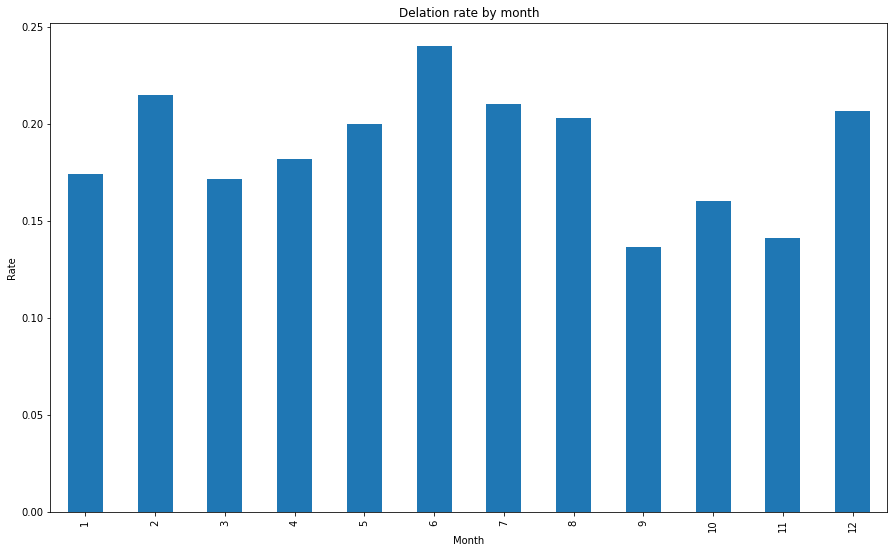

In [25]:
delayed_by_month.plot(
    kind="bar",
    title="Delation rate by month",
    xlabel="Month",
    ylabel="Rate",
    figsize=(15, 9)
)

### Grupujemy miesiące na wakacyjne lub nie 
> bardzo luźno stwierdzone

In [30]:
df['is_holiday_month'] = 0

holiday_months = [2, 6, 7, 8, 12]
is_holiday_month = df['month'].isin(holiday_months)

df.loc[is_holiday_month, "is_holiday_month"] = 1

,month,day_of_month,day_of_week,is_delayed,origin_city_name,dest_city_name,cancelled,is_holiday_month
0,1,6,7,0.0,"Atlanta, GA","Columbus, GA",0.0,0
1,1,7,1,0.0,"Atlanta, GA","Columbus, GA",0.0,0
2,1,8,2,0.0,"Atlanta, GA","Columbus, GA",0.0,0
3,1,9,3,0.0,"Atlanta, GA","Columbus, GA",0.0,0
4,1,10,4,0.0,"Atlanta, GA","Columbus, GA",0.0,0


In [31]:
df[["month", "is_holiday_month"]].drop_duplicates()

,month,is_holiday_month
0,1,0
0,2,1
0,3,0
0,4,0
0,5,0
0,6,1
0,7,1
0,8,1
0,9,0
0,10,0


<AxesSubplot:title={'center':'Delation rate by holiday month'}, xlabel='Month', ylabel='Rate'>

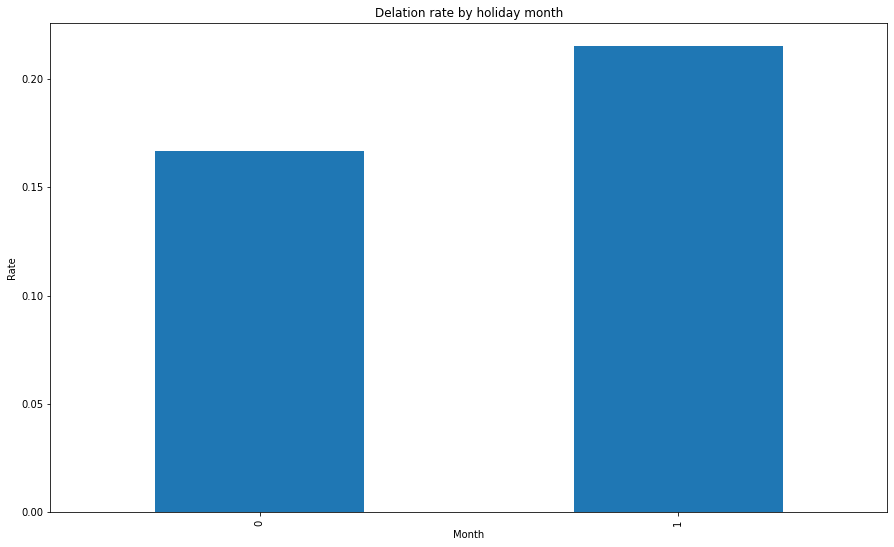

In [33]:
delayed_by_month = df.groupby(by=["is_holiday_month"])['is_delayed'].mean()
delayed_by_month.plot(
    kind="bar",
    title="Delation rate by holiday month",
    xlabel="Month",
    ylabel="Rate",
    figsize=(15, 9)
)

# Analiza według dnia tygodnia

Przy użyciu tabeli przestawnej (pivot tale)

In [35]:
pt = df.pivot_table(
    columns="month",
    index="day_of_week",  # rows  w Excel
    values="is_delayed",
    aggfunc="mean"
)

pt.style.background_gradient(cmap="Blues")

month,1,2,3,4,5,6,7,8,9,10,11,12
day_of_week,,,,,,,,,,,,
1,0.176532,0.224741,0.158959,0.233105,0.191381,0.253213,0.218369,0.181925,0.134631,0.163941,0.149755,0.250122
2,0.159540,0.205140,0.133505,0.136764,0.186516,0.229051,0.198951,0.216454,0.130726,0.134384,0.152916,0.197932
3,0.180140,0.232130,0.148382,0.126068,0.176749,0.234881,0.200905,0.217055,0.127281,0.156739,0.145126,0.194234
4,0.197573,0.242580,0.174171,0.167594,0.244330,0.244740,0.225515,0.235308,0.163040,0.187944,0.140392,0.178780
5,0.172066,0.232064,0.197003,0.228862,0.203144,0.216809,0.208057,0.209738,0.164910,0.193617,0.151536,0.186678
6,0.146455,0.164140,0.187171,0.172824,0.176796,0.227535,0.202682,0.160029,0.104117,0.111744,0.135677,0.198152
7,0.177158,0.189362,0.188872,0.201996,0.206383,0.269249,0.218829,0.193986,0.126240,0.163659,0.109607,0.224501


# Analiza według liczby lotów danego dnia

# Analiza przy pomocy trasy (dest <-> source airport)